<div style="border:solid Blue 2px; padding: 40px">
<h1>  Прогнозирование заказов такси</h1>
    
    
- Имеются исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

- Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

- Необходимо загрузить данные и выполнить их ресемплирование по одному часу, проанализировать, обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных, проверить данные на тестовой выборке и сделать выводы.
    
    Признаки
    - num_orders - кол-во заказов



<div style="border:solid Green 2px; padding: 40px">

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ресемплирование</a></span></li><li><span><a href="#Анализируем-тренды" data-toc-modified-id="Анализируем-тренды-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Анализируем тренды</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#TEST-RandomForest" data-toc-modified-id="TEST-RandomForest-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>TEST RandomForest</a></span></li><li><span><a href="#TEST-CatBoost" data-toc-modified-id="TEST-CatBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>TEST CatBoost</a></span></li></ul></li><li><span><a href="#Итог" data-toc-modified-id="Итог-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Заключение</a></span><ul class="toc-item"><li><span><a href="#Итоговый-комментарий" data-toc-modified-id="Итоговый-комментарий-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span><b>Итоговый комментарий</b></a></span></li></ul></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

#from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.isnull().sum()

num_orders    0
dtype: int64

In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
data.index.is_monotonic

True

<div style="border:solid Blue 2px; padding: 40px">
    
Ревью: 
- Пропусков и дубликатов нет
- Типы данных корректные
- Данные расположены в хронологическом порядке

## Анализ

### Ресемплирование

In [7]:
#ресемплируем и проверяем данные

data = data.resample('1H').sum()
print(data.index.is_monotonic)
print(data.isna().sum())

True
num_orders    0
dtype: int64


In [8]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Анализируем тренды

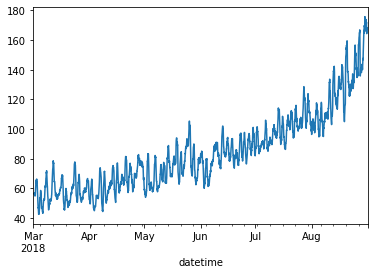

In [9]:
decomposed_trend = seasonal_decompose(data['num_orders'].resample('1H').sum())
decomposed_trend.trend.plot();

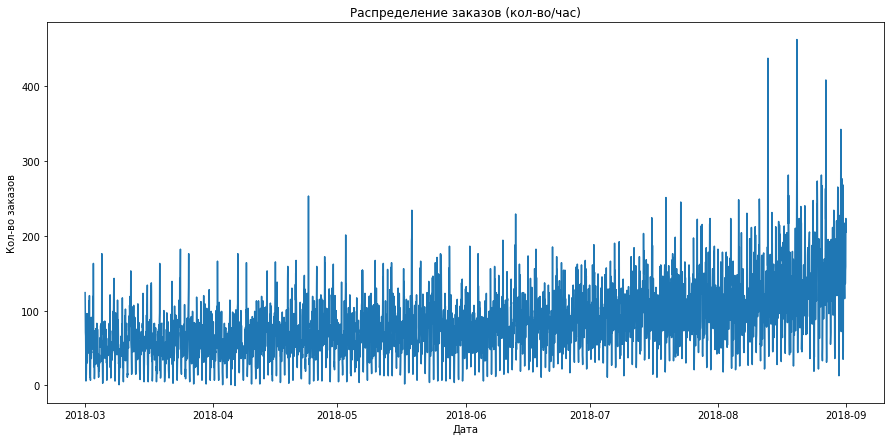

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(data)
plt.title('Распределение заказов (кол-во/час)')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

    Рассмотрим ближе одну неделю

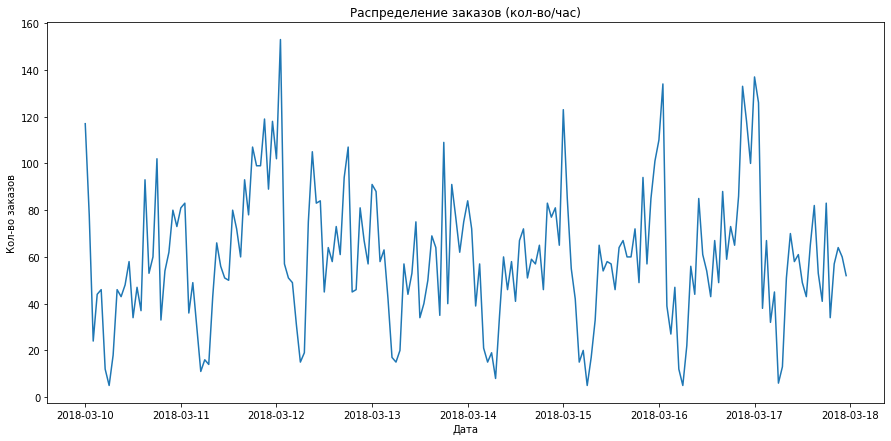

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(data['2018-03-10':'2018-03-17'])
plt.title('Распределение заказов (кол-во/час)')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

    Рассмотрим динамику в одном месяце - а также скользящее среднее

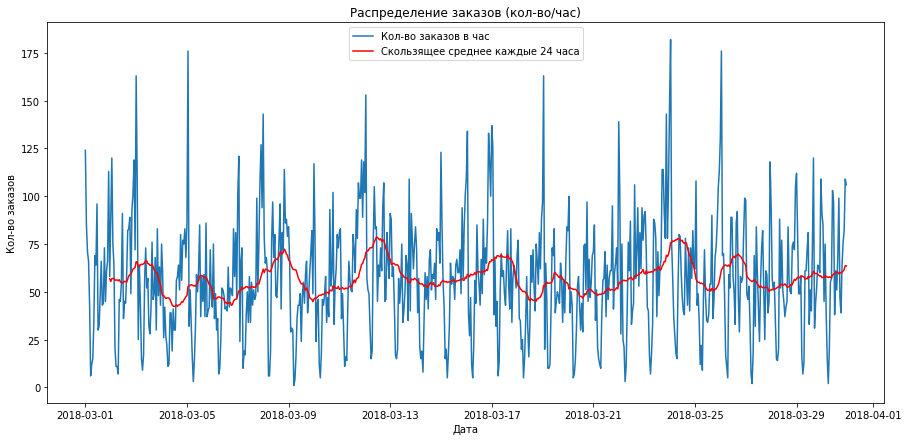

In [12]:
plt.figure(figsize=(15, 7))
plt.plot(data['2018-03-01':'2018-03-30'])
plt.plot(data['2018-03-01':'2018-03-30'].rolling(24).mean(), color='red')
plt.title('Распределение заказов (кол-во/час)')
plt.legend(['Кол-во заказов в час', 'Скользящее среднее каждые 24 часа'])
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

    Также рассмотрим одни сутки

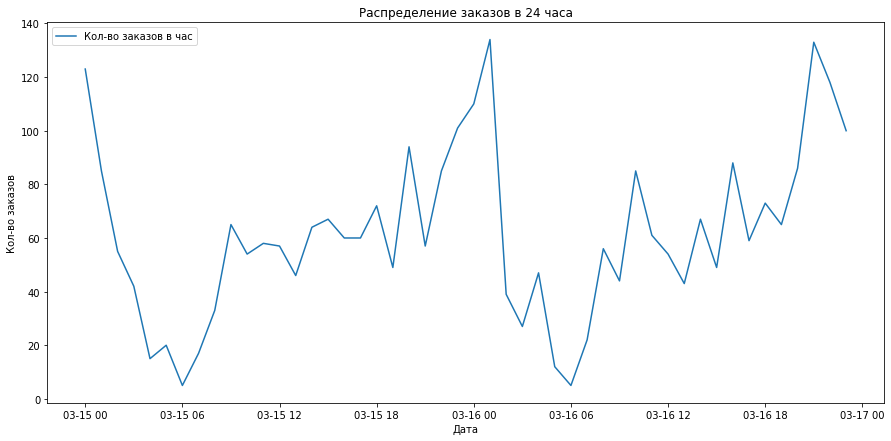

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(data['2018-03-15':'2018-03-16'])
plt.title('Распределение заказов в 24 часа')
plt.legend(['Кол-во заказов в час'])
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

<div style="border:solid Blue 2px; padding: 40px">
    
Вывод: 
- Провели графический анализ временных рядов, визуальная оценка
- Изучив тренды видно что наименьшее кол-во заказов с 0:0 до 6:00 утра. 
- Кол-во заказов в среднем за 6 месяцев увеличилось (возможно связано с ростом компании)

## Обучение

In [14]:
def make_features(data, lag, rolling_mean_size):
#    data['month'] = data.index.month
#    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for l in range(1, lag + 1):
        data[f'lag_{l}'] = data['num_orders'].shift(l)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data.dropna(inplace=True)

<div style="border:solid Blue 2px; padding: 40px">
    
 Примечание
    
- Факторы года и месяца не подходят - исторически у нас данных меньше года и каждый месяц представлен один раз. 
- Берем только факторы 
        - дня недели (есть недельная сезонность); 
        - часа (есть суточная сезонность); 
        - параметр lag=1 - параметр авторегрессии (поскольку есть влияние одного вчерашнего дня на сегодняшний)
        - rolling - скользящее среднее (ищем тренд по каким по скольки-то точкам) - Работает как линия сглаживания и колебаний и выбросов

In [15]:
make_features(data, 3, 24)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   dayofweek     4392 non-null   int64  
 2   hour          4392 non-null   int64  
 3   lag_1         4392 non-null   float64
 4   lag_2         4392 non-null   float64
 5   lag_3         4392 non-null   float64
 6   rolling_mean  4392 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 274.5 KB


In [17]:
#обязательно указать shuffle=False - что бы избежать перемешивания данных

train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [18]:
train = train.dropna()

In [19]:
print(train.shape)
print(test.shape)

(3952, 7)
(440, 7)


In [20]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [21]:
display(X_train.head())
display(X_test.head())

,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,4,0,58.0,113.0,66.0,56.833333
2018-03-02 01:00:00,4,1,90.0,58.0,113.0,55.416667
2018-03-02 02:00:00,4,2,120.0,90.0,58.0,56.875000
2018-03-02 03:00:00,4,3,75.0,120.0,90.0,57.041667
2018-03-02 04:00:00,4,4,64.0,75.0,120.0,56.958333


,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,
2018-08-13 16:00:00,0,16,175.0,102.0,119.0,139.541667
2018-08-13 17:00:00,0,17,144.0,175.0,102.0,139.166667
2018-08-13 18:00:00,0,18,152.0,144.0,175.0,140.708333
2018-08-13 19:00:00,0,19,104.0,152.0,144.0,141.791667
2018-08-13 20:00:00,0,20,91.0,104.0,152.0,142.166667


    Запишем функцию метрики rmse

In [22]:
#def rmse(y, predictions):
#    return (((y_test - predictions)**2).mean())**0.5


    Для того что бы не пользоваться встроенными кросс-валидацией, которая не учитывает что у нас временной ряд - уитывать что каждая валидационная часть выборки должна быть позже обучающей при каждом разбиении, будем пользоваться TimeSeriesSplit, GridSearchCV с параметрами gbm, param_grid=param_set, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv и verbose=1. И воспользуемя встроенной метрикой neg_root_mean_squared_error вместо функции rmse

### LinearRegression

In [27]:
model_LR = LinearRegression()

result_LR = cross_val_score(
              model_LR,
              X_train, 
              y_train, 
              cv = TimeSeriesSplit(n_splits=8), 
              n_jobs = -1, 
              scoring = 'neg_root_mean_squared_error').mean()

In [28]:
print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', result_LR)

Значение метрики RMSE на обучающей выборке для LinearRegression -31.288372730010668


### RandomForestRegressor

In [31]:
%%time

model_RF = RandomForestRegressor()

parameters = {'n_estimators':[50,100,150],
              'max_depth':[5,10]}

my_cv=TimeSeriesSplit(n_splits=8).split(X_train)

grid_RF = GridSearchCV(model_RF, 
                    parameters, 
                    cv=my_cv, 
                    scoring='neg_root_mean_squared_error', 
                    n_jobs=-1)
grid_RF.fit(X_train, y_train)

#-grid_RF.best_score_
model_param = grid_RF.best_params_

CPU times: user 17.5 s, sys: 104 ms, total: 17.6 s
Wall time: 17.7 s


In [32]:
print(model_param)

{'max_depth': 10, 'n_estimators': 150}


In [33]:
result_RF = -grid_RF.best_score_
print(result_RF)

24.66056612103381


### CatBoostRegressor

In [34]:
%%time

model_CatBoostRegressor = CatBoostRegressor(random_state = 1234, verbose = False)
parameters = {'learning_rate': [0.03, 0.1],
              'depth': [5, 10],
              'l2_leaf_reg': [3, 5]}
               
my_cv=TimeSeriesSplit(n_splits=8).split(X_train)
grid_Cat = GridSearchCV(model_CatBoostRegressor, 
                        parameters, 
                        cv=my_cv, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1)
grid_Cat.fit(X_train, y_train)

#-grid_Cat.best_score_
grid_Cat.best_params_

CPU times: user 4min 47s, sys: 6.47 s, total: 4min 53s
Wall time: 5min 41s


{'depth': 5, 'l2_leaf_reg': 5, 'learning_rate': 0.03}

In [35]:
result_Cat = -grid_Cat.best_score_
print(result_Cat)

24.60241344760097


    Результирующая табличка

In [39]:
result_models = pd.Series({
    "RMSE LinearRegression":result_LR,
    "RMSE RandomForest":result_RF,
    'RMSE CatBoost ':result_Cat})

In [40]:
result_models

RMSE LinearRegression   -31.288373
RMSE RandomForest        24.660566
RMSE CatBoost            24.602413
dtype: float64

<div style="border:solid Blue 2px; padding: 40px">
    
- У RandomForest и CatBoost одинаковый результат RMSE, но на обучение у первой модели уходит меньше времени (17.5 s)поэтому выбираем ее.

## Тестирование

### TEST RandomForest

In [41]:
model_RF_final = RandomForestRegressor(n_estimators=150, max_depth=10)

In [42]:
%%time

start = time.time()
fitted_model = model_RF_final.fit(X_train, y_train)
end = time.time()
total = end - start
print("Время обучения итоговой модели:", total)

Время обучения итоговой модели: 1.1195032596588135
CPU times: user 1.1 s, sys: 11.9 ms, total: 1.12 s
Wall time: 1.12 s


In [43]:
%%time

start = time.time()
predictions_model = fitted_model.predict(X_test) 
end = time.time()
total = end - start
rmse_model = (np.sqrt(mean_squared_error(y_test, predictions_model))) 

print ("RMSE RandomForest Итоговое:", rmse_model)
print ("Время предсказания RandomForest Итоговое:", total)

RMSE RandomForest Итоговое: 48.53295991778311
Время предсказания RandomForest Итоговое: 0.01925516128540039
CPU times: user 22.1 ms, sys: 0 ns, total: 22.1 ms
Wall time: 20.4 ms


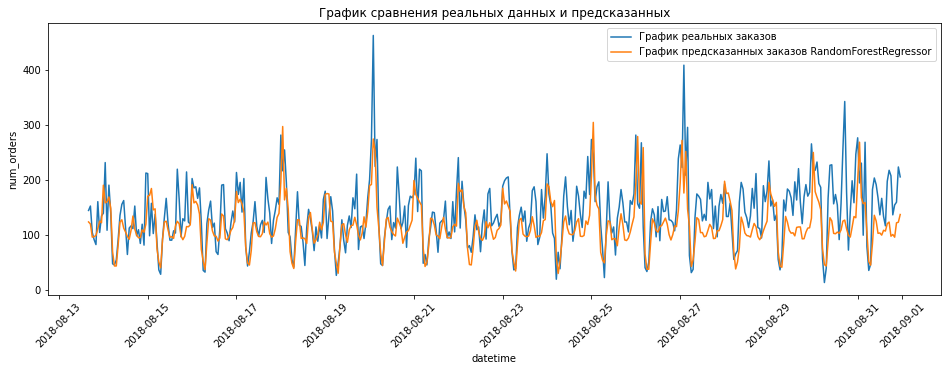

In [44]:
pred = pd.Series(predictions_model)
plt.figure(figsize=(16,5))
sns.lineplot(x=y_test.index, y=y_test, label='График реальных заказов')
sns.lineplot(x=y_test.index, y=pred, label='График предсказанных заказов RandomForestRegressor')

plt.legend(loc='upper right')
plt.title ('График сравнения реальных данных и предсказанных')

plt.xticks(rotation=45)
plt.show()

<div style="border:solid Blue 2px; padding: 40px">
    
    
- Итоговое RMSE модели RandomForestRegressor на тестовой выборке оказалось 48.5 и как видно из графика этот резльтат нам не подходит. 
- Пробуем протестировать CatBoost

### TEST CatBoost

In [45]:
model_CAT_final = CatBoostRegressor(depth=5, l2_leaf_reg=5, learning_rate=0.03)

In [46]:
%%time

start = time.time()
fitted_model = model_CAT_final.fit(X_train, y_train)
end = time.time()
total = end - start
print("Время обучения итоговой модели:", total)

0:	learn: 38.1552328	total: 1.74ms	remaining: 1.74s
1:	learn: 37.6465941	total: 3.5ms	remaining: 1.75s
2:	learn: 37.1985301	total: 5.06ms	remaining: 1.68s
3:	learn: 36.7078148	total: 6.11ms	remaining: 1.52s
4:	learn: 36.2665437	total: 7.33ms	remaining: 1.46s
5:	learn: 35.8883816	total: 8.32ms	remaining: 1.38s
6:	learn: 35.5294092	total: 9.25ms	remaining: 1.31s
7:	learn: 35.1119532	total: 10.3ms	remaining: 1.28s
8:	learn: 34.7178807	total: 11.3ms	remaining: 1.24s
9:	learn: 34.4171941	total: 12.2ms	remaining: 1.21s
10:	learn: 34.0509958	total: 13.6ms	remaining: 1.22s
11:	learn: 33.7568813	total: 14.6ms	remaining: 1.2s
12:	learn: 33.3841652	total: 15.8ms	remaining: 1.2s
13:	learn: 33.0636044	total: 17ms	remaining: 1.2s
14:	learn: 32.7552857	total: 18.4ms	remaining: 1.21s
15:	learn: 32.4484499	total: 19.3ms	remaining: 1.19s
16:	learn: 32.1754937	total: 20.4ms	remaining: 1.18s
17:	learn: 31.8757737	total: 21.3ms	remaining: 1.16s
18:	learn: 31.6426156	total: 22.2ms	remaining: 1.15s
19:	learn

In [47]:
%%time

start = time.time()
predictions_model_Cat = fitted_model.predict(X_test) 
end = time.time()
total = end - start
rmse_model = (np.sqrt(mean_squared_error(y_test, predictions_model))) 

print ("RMSE CatBoostRegressor Итоговое:", rmse_model)
print ("Время предсказания CatBoostRegressor Итоговое:", total)

RMSE CatBoostRegressor Итоговое: 48.53295991778311
Время предсказания CatBoostRegressor Итоговое: 0.002118349075317383
CPU times: user 609 µs, sys: 3.85 ms, total: 4.46 ms
Wall time: 2.91 ms


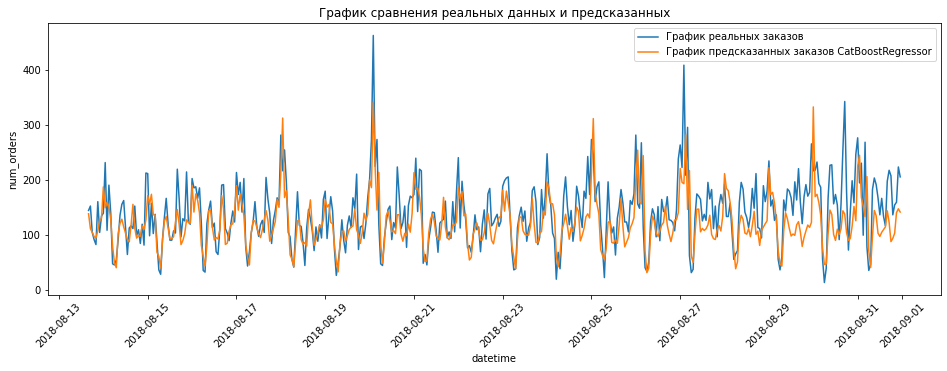

In [48]:
pred = pd.Series(predictions_model_Cat)
plt.figure(figsize=(16,5))
sns.lineplot(x=y_test.index, y=y_test, label='График реальных заказов')
sns.lineplot(x=y_test.index, y=pred, label='График предсказанных заказов CatBoostRegressor')

plt.legend(loc='upper right')
plt.title ('График сравнения реальных данных и предсказанных')

plt.xticks(rotation=45)
plt.show()

<div style="border:solid Blue 2px; padding: 40px">
    
    
- Итоговое RMSE модели CatBoostRegressor на тестовой выборке оказалось 48.5 - Тот же результат что и у модели выше.
Выбор в пользу модели CatBoost поскольку время на обучение и предсказание тратиться меньше.

## Заключение

<div style="border:solid Blue 2px; padding: 40px">

<h3><b>Итоговый комментарий</b></h3> 
    
    - Провели предподготовку данных, анализ, ресемплирование
    - Обучили три модели 
            - LinearRegression, 
            - RandomForestRegressor, 
            - CatBoostRegressor
    - RMSE рекомендуемой модели CatBoostRegressor на тестовой выборке 47 (требование не более 48)
    
    Время обучения итоговой модели CatBoostRegressor: 1.7 с
    Время предсказания на тестовой выборке 0.002 с